# Part 1:  Visualizing Articles with Word Clouds

#### Recommended reading:

Bird, Steven, et al. Natural Language Processing with Python. O'Reilly, 2009.

Géron, Aurélien. Hands-on Machine Learning with Scikit-Learn & TensorFlow. O’Reilly,  2017.

Petrou, Theodore. Pandas Cookbook. Packt Publishing, 2017.

**For Markdown Syntax:**

https://www.markdownguide.org/basic-syntax/

**For Model Evaluation:**

https://scikit-learn.org/stable/modules/model_evaluation.html

In [1]:
#Get directory path and change working path
import os
os.getcwd( )

'C:\\Users\\Yrelav\\Documents\\Cognizant\\Training\\Gen_C_Instruction\\NLP\\Articles'

In [2]:
os.chdir('/Users/Yrelav/Documents/Cognizant/Training/Gen_C_Instruction/NLP/Articles') 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Read in the data
df = pd.read_csv('Articles_genc.csv')
print(df.shape)
print(df.columns)
df.dtypes

(842, 2)
Index(['text', 'Tag_1'], dtype='object')


text     object
Tag_1    object
dtype: object

### Take a look at the dataframe

In [4]:
df.head()

,text,Tag_1
0,To take great managing from theory to practice...,coaching
1,"When you wake up in the morning, what is the p...",wellness
2,It’s common knowledge that helping employees s...,productivity
3,We live in a society where hustle and achievem...,wellness
4,I remember the conversations well because we h...,communication


In [5]:
df['Tag_1'].value_counts()

None             224
coaching          48
wellness          31
communication     17
productivity      16
Name: Tag_1, dtype: int64

Right now we can see that this is a multi-class dataset and that it is very unbalanced! The 'None' category is more than 4 times larger than the others and there are 5 different classes (Tag_1 categories). 

We can try to use a multi-class classifier, but they will struggle with a training set this small and unbalanced. The way to handle this is to set it up as a sparse matrix, sometimes called hot-one encoding or hot-one vectors. More on this later. Now, let's see how well these categories capture the variation in these articles by visualizing them.

### Get the sizes of the training and testing sets.

In [6]:
df_training = df[df['Tag_1'].notnull()]
print(df_training.shape)
print('')

df_testing = df[df['Tag_1'].isnull()]
df_testing = df_testing[df_testing.text.notnull()]
print(df_testing.shape)

print('Number of labeled articles:  ',df.Tag_1.notnull().sum())


(336, 2)

(501, 2)
Number of labeled articles:   336


In [7]:
#Check if any are null in training set
print(df_training.isnull().sum())

text     1
Tag_1    0
dtype: int64


In [8]:
#Remove the null row
df_training = df_training.dropna()
df_training.isnull().sum()

text     0
Tag_1    0
dtype: int64

### Construct a sparse matrix of tags for training set and testing set

In [9]:
#Create a df for the tags
df_tags = pd.DataFrame(columns = ['coaching','wellness','communication','productivity', 'None'])

#Join with the training and testing dfs: df_train and df_test
df_train = pd.concat([df_training, df_tags], axis=1, sort=False)
df_test = pd.concat([df_testing, df_tags], axis=1, sort=False)

#Fill missing values with zero (0): df_matrix
df_train[['coaching','wellness','communication','productivity', 'None']]\
= df_train[['coaching','wellness','communication','productivity', 'None']].fillna(0)

#Fill missing values with zero (0): df_matrix_pred
df_test[['coaching','wellness','communication','productivity', 'None']]\
= df_test[['coaching','wellness','communication','productivity', 'None']].fillna(0)

#Drop any text that is empty (keep only if not equal to empty cell)
df_train = df_train[df_train.text != '[]']
df_test = df_test[df_test.text != '[]']

In [10]:
#Create list of category names
categories = list(df_train.columns.values)
start_ = categories.index('coaching')
stop_ = len(categories)

#Create sparse matrix for 4 tags
for j in range(start_,stop_):
        df_train[categories[j]] = np.where(df_train['Tag_1'] == categories[j], 1, df_train[categories[j]])
        
df_train[['Tag_1', 'coaching','wellness','communication','productivity', 'None']].head(10)    

,Tag_1,coaching,wellness,communication,productivity,None
0,coaching,1,0,0,0,0
1,wellness,0,1,0,0,0
2,productivity,0,0,0,1,0
3,wellness,0,1,0,0,0
4,communication,0,0,1,0,0
5,coaching,1,0,0,0,0
6,None,0,0,0,0,1
7,wellness,0,1,0,0,0
8,productivity,0,0,0,1,0
9,None,0,0,0,0,1


### Import packages for preprocessing and classification

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Import packages for algorithm analysis
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

#Import algorithm packages.
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yrelav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Create a table to examine the distribution of tags

In [12]:
df_sparse = df_train.drop(['text', 'Tag_1'], axis=1)
counts = []
priors = []
categories = list(df_sparse.columns.values)
for i in categories:
    numarts = df_sparse[i].sum()
    counts.append((i, numarts))

df_stats = pd.DataFrame(counts, columns=['Categories', 'Number_of_articles'])
total = df_stats.Number_of_articles.sum()

df_stats['priors'] = df_stats['Number_of_articles']/total

print(df_stats)
print('')
print('Total number of labels:  ', total)


      Categories  Number_of_articles    priors
0       coaching                  48  0.143284
1       wellness                  31  0.092537
2  communication                  17  0.050746
3   productivity                  16  0.047761
4           None                 223  0.665672

Total number of labels:   335


## Experimenting with multi-label classification

Text(0.5, 0, 'Category')

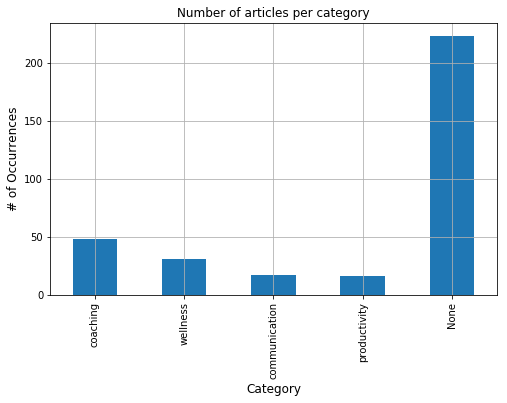

In [13]:
df_stats.plot(x='Categories', y='Number_of_articles', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of articles per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)

### Check distribution of words in the texts

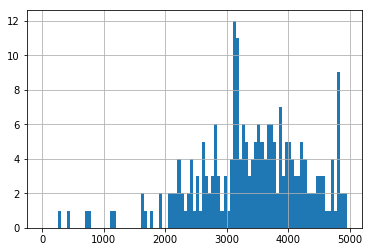

In [14]:
lens = df_train['text'].str.len()
lens.hist(bins = np.arange(0,5000,50))

## Preprocessing

In [15]:
import re
#Define a function to clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"http://\S+", " ", text)
    text = re.sub(r"https://\S+", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r"co", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

#### What is a lambda function?

https://www.python-course.eu/lambda.php

#### Example

r = map(func, seq)

The first argument func is the name of a function and the second a sequence (e.g. a list) seq. map() applies the function func to all the elements of the sequence seq. It returns a new list with the elements changed by func


In [16]:
#Make sure all entries in df_train['text'] are strings
df_train['text'] = df_train['text'].astype(str)

#Clean the text 
df_train['text'] = df_train['text'].map(lambda x : clean_text(x))

## Visualize with a wordcloud all of the tweets

In [17]:
# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [18]:
# Make text for all tweets
text = list(df_train.text)

summary1 = []
for i in range(len(text)):
    summary = ' '.join(str(x) for x in text)
    summary1.append(summary) 
alltext = summary1[0] 

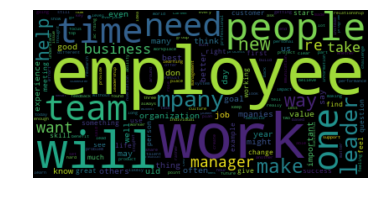

In [19]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(alltext)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
#wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud.png')
plt.show()

#### Wordcloud for all the articles.

### Visualize with wordclouds for each category

In [20]:
categories

['coaching', 'wellness', 'communication', 'productivity', 'None']

In [21]:
# Make text for each category tweets: A better way would be to use a 'For' statement and iterate over the categories
df_coach = df_train[df_train['coaching'] == 1]
df_well = df_train[df_train['wellness'] == 1]
df_comm = df_train[df_train['communication'] == 1]
df_prod = df_train[df_train['productivity'] == 1]
df_None = df_train[df_train['None'] == 1]

text_coach = list(df_coach['text'].values)
text_well = list(df_well['text'].values)
text_comm = list(df_comm['text'].values)
text_prod = list(df_prod['text'].values)
text_None = list(df_None['text'].values)

In [22]:
#Coaching text
summary_coach = []
for i in range(len(text_coach)):
    summary = ' '.join(str(x) for x in text_coach)
    summary_coach.append(summary) 
alltext_coach = summary_coach[0] 

In [23]:
#Wellness text
summary_well = []
for i in range(len(text_well)):
    summary = ' '.join(str(x) for x in text_well)
    summary_well.append(summary) 
alltext_well = summary_well[0] 

In [24]:
#Communication text
summary_comm = []
for i in range(len(text_comm)):
    summary = ' '.join(str(x) for x in text_comm)
    summary_comm.append(summary) 
alltext_comm = summary_comm[0] 

In [25]:
#Productivity text
summary_prod = []
for i in range(len(text_prod)):
    summary = ' '.join(str(x) for x in text_prod)
    summary_prod.append(summary) 
alltext_prod = summary_prod[0] 

In [26]:
#Productivity text
summary_None = []
for i in range(len(text_prod)):
    summary = ' '.join(str(x) for x in text_None)
    summary_None.append(summary) 
alltext_None = summary_None[0] 

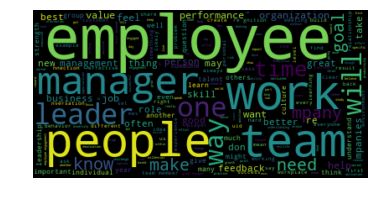

In [27]:
# Create and generate a word cloud image for positive tweets:
wordcloud = WordCloud().generate(alltext_coach)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
#wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_pos.png')

plt.show()

#### Wordcloud for coaching articles.

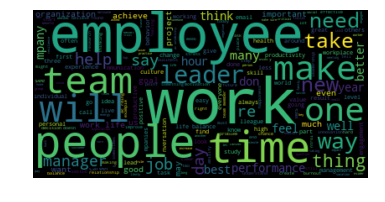

In [28]:
# Create and generate a word cloud image for negative tweets:
wordcloud = WordCloud().generate(alltext_well)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
#wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_neg.png')

plt.show()

#### Wordcloud for wellness articles. 

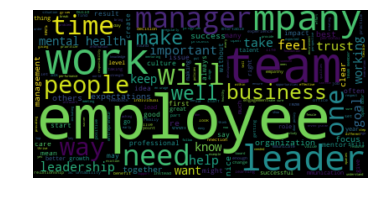

In [29]:
# Create and generate a word cloud image for negative tweets:
wordcloud = WordCloud().generate(alltext_comm)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
#wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_neg.png')

plt.show()

#### Wordcloud for communication articles. 

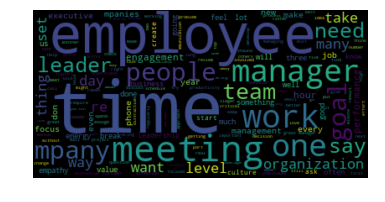

In [30]:
# Create and generate a word cloud image for negative tweets:
wordcloud = WordCloud().generate(alltext_prod)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
#wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_neg.png')

plt.show()

#### Word cloud for productivity articles.

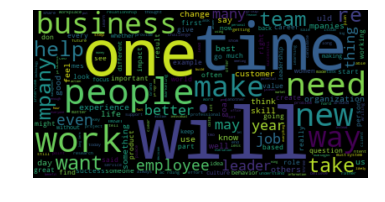

In [31]:
# Create and generate a word cloud image for negative tweets:
wordcloud = WordCloud().generate(alltext_None)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
#wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_neg.png')

plt.show()

#### Word cloud for None articles.

# Part 2:  Classifying Articles: Testing and Tuning

### Vectorize/featurize the data 

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [32]:
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)

Xv = vectorizer.fit_transform(df_train.text)
Xt = featurizer.fit_transform(df_train.text)

## Multinomial Naive Bayes

In [33]:
import warnings
warnings.filterwarnings("ignore")

i=1

vectors = [Xv, Xt]
for vect in vectors:
    
    conmatrxNB = []
    precisionNB = []
    recallNB = []
    f1NB = []

    clf_NB = MultinomialNB()

    alphas = [.00001,.0001, .001, .01, .1, 1, 5, 10, 50]

    # Create hyperparameter options
    hyperparameters = dict(alpha=alphas)

    # Create grid search using 5-fold cross validation
    clf_tune = GridSearchCV(clf_NB, hyperparameters, cv=5, scoring='precision')               


    for category in categories:
        # Fit grid search
        best_model = clf_tune.fit(vect, df_train[category])                
        alpha = best_model.best_estimator_.get_params()['alpha']
    
        clf_tunedNB = MultinomialNB(alpha=alpha)
    
        y_train_pred = cross_val_predict(clf_tunedNB, vect, df_train[category], cv=5)

    
        cmNB = confusion_matrix(df_train[category], y_train_pred)
        conmatrxNB.append(cmNB)
        precNB = precision_score(df_train[category], y_train_pred)    
        precisionNB.append(precNB)
        recNB = recall_score(df_train[category], y_train_pred)
        recallNB.append(recNB)
        fNB = f1_score(df_train[category], y_train_pred)
        f1NB.append(fNB)
        

    
    dictNB = {'Categories':categories, 'Confusion Matrix':conmatrxNB, 'Precision_NB':precisionNB, 
          'Recall_NB':recallNB, 'F1_NB':f1NB}


    df_NB = pd.DataFrame(dictNB) 
    #df_NB.to_csv('Results_NB_HBR.csv')

    if i == 1:
        print('CountVectorizer\n')
        i += 1
    else:
        print('\nTfidfVectorizer')
    
    print(df_NB)

CountVectorizer

      Categories       Confusion Matrix  Precision_NB  Recall_NB     F1_NB
0       coaching  [[236, 51], [19, 29]]      0.362500   0.604167  0.453125
1       wellness  [[280, 24], [19, 12]]      0.333333   0.387097  0.358209
2  communication    [[313, 5], [14, 3]]      0.375000   0.176471  0.240000
3   productivity   [[301, 18], [10, 6]]      0.250000   0.375000  0.300000
4           None  [[88, 24], [49, 174]]      0.878788   0.780269  0.826603

TfidfVectorizer
      Categories       Confusion Matrix  Precision_NB  Recall_NB     F1_NB
0       coaching    [[286, 1], [45, 3]]      0.750000   0.062500  0.115385
1       wellness    [[304, 0], [31, 0]]      0.000000   0.000000  0.000000
2  communication    [[318, 0], [17, 0]]      0.000000   0.000000  0.000000
3   productivity    [[319, 0], [16, 0]]      0.000000   0.000000  0.000000
4           None  [[64, 48], [20, 203]]      0.808765   0.910314  0.856540


CountVectorizer performed better so we will use it with NB.

In [34]:
#Run model with CountVectorizer and get AUC scores

conmatrxNB = []
precisionNB = []
recallNB = []
f1NB = []
aucNB = []
aveprecNB = []

clf_NB = MultinomialNB()

alphas = [.00001,.0001, .001, .01, .1, 1, 5, 10, 50]

# Create hyperparameter options
hyperparameters = dict(alpha=alphas)

# Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_NB, hyperparameters, cv=5, scoring='precision')               


for category in categories:
    # Fit grid search
    best_model = clf_tune.fit(Xv, df_train[category])                
    alpha = best_model.best_estimator_.get_params()['alpha']
    
    clf_tunedNB = MultinomialNB(alpha=alpha)
    
    y_train_pred = cross_val_predict(clf_tunedNB, Xv, df_train[category], cv=5)

    cmNB = confusion_matrix(df_train[category], y_train_pred)
    conmatrxNB.append(cmNB)
    precNB = precision_score(df_train[category], y_train_pred)    
    precisionNB.append(precNB)
    recNB = recall_score(df_train[category], y_train_pred)
    recallNB.append(recNB)
    fNB = f1_score(df_train[category], y_train_pred)
    f1NB.append(fNB)
    
    #Make training and testing data.
    y = df_train[category].values.astype(np.int)
    
    X_train, X_test, y_train, y_test = train_test_split(Xv, y, test_size=0.3)
    
    #Fit the tuned classifier to the training data.
    clf_tunedNB.fit(X_train, y_train)

    #Calculate AUC score with the test set
    y_pred = clf_tunedNB.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_nb = roc_auc_score(y_test, y_pred)
    aucNB.append(auc_nb)
    

dictNB = {'Categories':categories, 'Confusion Matrix':conmatrxNB, 'Precision_NB':precisionNB, 
          'Recall_NB':recallNB, 'F1_NB':f1NB, 'auc_NB':aucNB}


df_NB = pd.DataFrame(dictNB) 
#df_NB.to_csv('Results_NB_HBR.csv')
    
df_NB

,Categories,Confusion Matrix,Precision_NB,Recall_NB,F1_NB,auc_NB
0,coaching,"[[236, 51], [19, 29]]",0.362500,0.604167,0.453125,0.769608
1,wellness,"[[280, 24], [19, 12]]",0.333333,0.387097,0.358209,0.602528
2,communication,"[[313, 5], [14, 3]]",0.375000,0.176471,0.240000,0.494681
3,productivity,"[[301, 18], [10, 6]]",0.250000,0.375000,0.300000,0.658333
4,None,"[[88, 24], [49, 174]]",0.878788,0.780269,0.826603,0.814069


## Tune & Train the hyperparameters for LinearSVC

In [35]:
import warnings
warnings.filterwarnings("ignore")

i=1

vectors = [Xv, Xt]
for vect in vectors:

    conmatrxSVC = []
    precisionSVC = []
    recallSVC = []
    f1SVC = []
    
    clf_SVC = LinearSVC(random_state=42)

    loss = ['hinge', 'squared_hinge']
    
    C = [1, 10, 100, 1000, 10000]

    # Create hyperparameter options
    hyperparameters = dict(C=C, loss=loss)

    # Create grid search using 5-fold cross validation
    clf_tune = GridSearchCV(clf_SVC, hyperparameters, cv=5, scoring='precision')   

    for category in categories:
        # Fit grid search
        best_model = clf_tune.fit(vect, df_train[category])                
    
        SVCloss = best_model.best_estimator_.get_params()['loss']
        SVC_C = best_model.best_estimator_.get_params()['C']
    
        clf_tunedSVC = LinearSVC(random_state=42, loss=SVCloss, C=SVC_C)
    
        y_train_pred = cross_val_predict(clf_tunedSVC, vect, df_train[category], cv=5)
   
        cmSVC = confusion_matrix(df_train[category], y_train_pred)
        conmatrxSVC.append(cmSVC)
        precSVC = precision_score(df_train[category], y_train_pred)    
        precisionSVC.append(precSVC)
        recSVC = recall_score(df_train[category], y_train_pred)
        recallSVC.append(recSVC)
        fSVC = f1_score(df_train[category], y_train_pred)
        f1SVC.append(fSVC)
    
    dictSVC = {'Categories':categories, 'Confusion Matrix':conmatrxSVC, 'Precision_SVC':precisionSVC, 
           'Recall_SVC':recallSVC, 'F1_SVC':f1SVC}
    df_SVC = pd.DataFrame(dictSVC) 
    #df_SVC.to_csv('Results_SVC_HBR.csv')

    if i == 1:
        print('CountVectorizer\n')
        i += 1
    else:
        print('\nTfidfVectorizer')
    
    print(df_SVC)

CountVectorizer

      Categories       Confusion Matrix  Precision_SVC  Recall_SVC    F1_SVC
0       coaching  [[258, 29], [28, 20]]       0.408163    0.416667  0.412371
1       wellness  [[281, 23], [19, 12]]       0.342857    0.387097  0.363636
2  communication   [[304, 14], [15, 2]]       0.125000    0.117647  0.121212
3   productivity    [[311, 8], [12, 4]]       0.333333    0.250000  0.285714
4           None  [[71, 41], [25, 198]]       0.828452    0.887892  0.857143

TfidfVectorizer
      Categories       Confusion Matrix  Precision_SVC  Recall_SVC    F1_SVC
0       coaching    [[287, 0], [45, 3]]       1.000000    0.062500  0.117647
1       wellness    [[302, 2], [28, 3]]       0.600000    0.096774  0.166667
2  communication   [[306, 12], [15, 2]]       0.142857    0.117647  0.129032
3   productivity    [[319, 0], [13, 3]]       1.000000    0.187500  0.315789
4           None  [[76, 36], [22, 201]]       0.848101    0.901345  0.873913


It looks like TfidfVectorizer works better - 1.00 precision! This looks fantastic! It's not reporting any false positives for coaching or productivity so SVC looks like a good candidate for those categories. But remember, we actually have 16 productivity articles and it's only predicting 3. That's the trade-off with precision scores - we will get fewer predicted in order to be very sure that the ones we predict are the most correct. There were 48 coaching articles, but here the model only predicts 3. That's a significant production loss, but it will likely get better with a larger training set. 

We can also tinker a bit with the hyperparameters. By looking for the best fit, we actually run into overfitting. If the problem is too few predicted articles, and we are willing to have a bit of error, we can introduce some bias to get better predictions. Or, we can switch to 'Recall' or 'F1' as scoring functions. 

Communication is looking like a difficult category to predict. 

In [36]:
#Run model with TfidfVectorizer and get AUC scores

conmatrxSVC = []
precisionSVC = []
recallSVC = []
f1SVC = []
aucSVC = []

clf_SVC = LinearSVC(random_state=42)

loss = ['hinge', 'squared_hinge']
    
C = [1, 10, 100, 1000, 10000]

# Create hyperparameter options
hyperparameters = dict(C=C, loss=loss)

# Create grid search using 5-fold cross validation
clf_tune = GridSearchCV(clf_SVC, hyperparameters, cv=5, scoring='precision')   


for category in categories:
    
    # Fit grid search
    best_model = clf_tune.fit(Xt, df_train[category])                
    
    SVCloss = best_model.best_estimator_.get_params()['loss']
    SVC_C = best_model.best_estimator_.get_params()['C']
    
    clf_tunedSVC = LinearSVC(random_state=42, loss=SVCloss, C=SVC_C)
    
    y_train_pred = cross_val_predict(clf_tunedSVC, Xt, df_train[category], cv=5)
   
    #Get algorithm performance measures
    cmSVC = confusion_matrix(df_train[category], y_train_pred)
    conmatrxSVC.append(cmSVC)
    precSVC = precision_score(df_train[category], y_train_pred)    
    precisionSVC.append(precSVC)
    recSVC = recall_score(df_train[category], y_train_pred)
    recallSVC.append(recSVC)
    fSVC = f1_score(df_train[category], y_train_pred)
    f1SVC.append(fSVC)
    
    #Make training and testing data.
    y = df_train[category].values.astype(np.int)
    
    X_train, X_test, y_train, y_test = train_test_split(Xv, y, test_size=0.3)
    
    #Fit the tuned classifier to the training data.
    clf_tunedSVC.fit(X_train, y_train)

    #Calculate AUC score with the test set
    y_pred = clf_tunedSVC.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_svc = roc_auc_score(y_test, y_pred)
    aucSVC.append(auc_svc)
    
dictSVC = {'Categories':categories, 'Confusion Matrix':conmatrxSVC, 'Precision_SVC':precisionSVC, 
           'Recall_SVC':recallSVC, 'F1_SVC':f1SVC, 'auc_SVC':aucSVC}
df_SVC = pd.DataFrame(dictSVC) 
#df_SVC.to_csv('Results_SVC_HBR.csv')

df_SVC

,Categories,Confusion Matrix,Precision_SVC,Recall_SVC,F1_SVC,auc_SVC
0,coaching,"[[287, 0], [45, 3]]",1.000000,0.062500,0.117647,0.540809
1,wellness,"[[302, 2], [28, 3]]",0.600000,0.096774,0.166667,0.632292
2,communication,"[[306, 12], [15, 2]]",0.142857,0.117647,0.129032,0.478947
3,productivity,"[[319, 0], [13, 3]]",1.000000,0.187500,0.315789,0.758333
4,None,"[[76, 36], [22, 201]]",0.848101,0.901345,0.873913,0.730574


## Tune & Train Hyperparameters for LR

All solvers support the l2 penalty (‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers do not support L1 penalty). So, hyperparameters are optimized using the L2 penalty.

In [37]:
i=1

vectors = [Xv, Xt]
for vect in vectors:

    conmatrxLR = []
    precisionLR = []
    recallLR = []
    f1LR = []

    clf_LR = LogisticRegression(random_state=42)
    
    # Create regularization hyperparameter space
    C = np.logspace(-4, 4, 20)

    solver = ['liblinear', 'sag', 'newton-cg', 'saga', 'lbfgs']

    # Create hyperparameter options
    hyperparameters = dict(solver = solver, C=C)

    # Create grid search using 5-fold cross validation
    clf_tuneLR = GridSearchCV(clf_LR, hyperparameters, cv=5, verbose=0, scoring='precision')       

    for category in categories:
    
        # Fit grid search
        best_model = clf_tuneLR.fit(vect, df_train[category])                
        LRsolver = best_model.best_estimator_.get_params()['solver']
        LR_C = best_model.best_estimator_.get_params()['C']      

        clf_tunedLR = LogisticRegression(penalty='l2', C=LR_C, solver=LRsolver)
    
        y_train_pred = cross_val_predict(clf_tunedLR, vect, df_train[category], cv=5)
    
        cmLR = confusion_matrix(df_train[category], y_train_pred)
        conmatrxLR.append(cmLR)
        precLR = precision_score(df_train[category], y_train_pred)    
        precisionLR.append(precLR)
        recLR = recall_score(df_train[category], y_train_pred)
        recallLR.append(recLR)
        fLR = f1_score(df_train[category], y_train_pred)
        f1LR.append(fLR)
        
        

    dictLR = {'Categories':categories, 'Confusion Matrix':conmatrxLR, 'Precision_LR':precisionLR, 
           'Recall_LR':recallLR, 'F1_LR':f1LR}
    df_LR = pd.DataFrame(dictLR) 
    #df_LR.to_csv('Results_LR_HBR.csv')
 
    if i == 1:
        print('CountVectorizer\n')
        i += 1
    else:
        print('\nTfidfVectorizer')
    
    print(df_LR)

CountVectorizer

      Categories       Confusion Matrix  Precision_LR  Recall_LR     F1_LR
0       coaching    [[282, 5], [42, 6]]      0.545455   0.125000  0.203390
1       wellness    [[300, 4], [26, 5]]      0.555556   0.161290  0.250000
2  communication    [[312, 6], [16, 1]]      0.142857   0.058824  0.083333
3   productivity    [[317, 2], [13, 3]]      0.600000   0.187500  0.285714
4           None  [[75, 37], [25, 198]]      0.842553   0.887892  0.864629

TfidfVectorizer
      Categories       Confusion Matrix  Precision_LR  Recall_LR     F1_LR
0       coaching    [[282, 5], [40, 8]]      0.615385   0.166667  0.262295
1       wellness    [[303, 1], [27, 4]]      0.800000   0.129032  0.222222
2  communication   [[307, 11], [16, 1]]      0.083333   0.058824  0.068966
3   productivity    [[318, 1], [13, 3]]      0.750000   0.187500  0.300000
4           None  [[73, 39], [20, 203]]      0.838843   0.910314  0.873118


Ah! Logistic regression is consistently good with classification on small unbalanced datasets. Here it is handling 3 out of 5 classes quite well with TfidfVectorizer. Note that SVC handled coaching and productivity very well. We can use SVC for those categories, and LR for wellness. Now we just have to work out communication. But if there is only one category left over then we can use 

In [38]:
#Run model with TfidfVectorizer and get AUC scores

conmatrxLR = []
precisionLR = []
recallLR = []
f1LR = []
aucLR = []

# Create regularization hyperparameter space
C = np.logspace(-4, 4, 20)

solver = ['liblinear', 'sag', 'newton-cg', 'saga', 'lbfgs']

# Create hyperparameter options
hyperparameters = dict(solver = solver, C=C)

# Create grid search using 5-fold cross validation
clf_tuneLR = GridSearchCV(clf_LR, hyperparameters, cv=5, verbose=0, scoring='precision')       

for category in categories:
    
    # Fit grid search
    best_model = clf_tuneLR.fit(Xt, df_train[category])                
    LRsolver = best_model.best_estimator_.get_params()['solver']
    LR_C = best_model.best_estimator_.get_params()['C']      

    clf_tunedLR = LogisticRegression(penalty='l2', C=LR_C, solver=LRsolver)
    
    y_train_pred = cross_val_predict(clf_tunedLR, Xt, df_train[category], cv=5)
    
    cmLR = confusion_matrix(df_train[category], y_train_pred)
    conmatrxLR.append(cmLR)
    precLR = precision_score(df_train[category], y_train_pred)    
    precisionLR.append(precLR)
    recLR = recall_score(df_train[category], y_train_pred)
    recallLR.append(recLR)
    fLR = f1_score(df_train[category], y_train_pred)
    f1LR.append(fLR)
    
    #Make training and testing data.
    y = df_train[category].values.astype(np.int)
    
    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3)
    
    #Fit the tuned classifier to the training data.
    clf_tunedLR.fit(X_train, y_train)

    #Calculate AUC score with the test set
    y_pred = clf_tunedLR.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_lr = roc_auc_score(y_test, y_pred)
    aucLR.append(auc_lr)

dictLR = {'Categories':categories, 'Confusion Matrix':conmatrxLR, 'Precision_LR':precisionLR, 
           'Recall_LR':recallLR, 'F1_LR':f1LR, 'auc_LR':aucLR}
df_LR = pd.DataFrame(dictLR) 
#df_LR.to_csv('Results_LR.csv')

df_LR

,Categories,Confusion Matrix,Precision_LR,Recall_LR,F1_LR,auc_LR
0,coaching,"[[282, 5], [41, 7]]",0.583333,0.145833,0.233333,0.558824
1,wellness,"[[303, 1], [27, 4]]",0.800000,0.129032,0.222222,0.500000
2,communication,"[[307, 11], [16, 1]]",0.083333,0.058824,0.068966,0.489899
3,productivity,"[[318, 1], [13, 3]]",0.750000,0.187500,0.300000,0.500000
4,None,"[[73, 39], [20, 203]]",0.838843,0.910314,0.873118,0.755869


There's one more thing we can do to improve classification scores. Since the dataset is unbalanced, many more 'None' articles, we can remove the None articles and run our models just on the other articles. We'll do that and use Logistic regression as an example and see how we do. This is called **"cascading"**. We use a model on the whole set that has the highest precsision to predict one of the categories. Then we take it out of the dataset. We can then try the classifiers again to see how they perform on the remaining categories. We're not going to actually predict on the test set just yet, so we can go ahead and just take out the None articles and see if the classifiers (we'll use logistic regression to illustrate) get better.

In [39]:
df_train.shape

(335, 7)

In [40]:
#Take out the None category. 
df_train_NN = df_train.drop(df_train[df_train['None'] == 1].index)
df_train_NN.shape

(112, 7)

In [41]:
categories

['coaching', 'wellness', 'communication', 'productivity', 'None']

In [42]:
#RE-vectorize the new training set.
vectorizer = CountVectorizer(stop_words='english',binary=False,max_df=.4, ngram_range=(1, 1),
                                     min_df=1,strip_accents='unicode',max_features=200)

featurizer = TfidfVectorizer(stop_words='english',binary=False,max_df=.4,min_df=1, max_features=200)

XvN = vectorizer.fit_transform(df_train_NN.text)
XtN = featurizer.fit_transform(df_train_NN.text)

In [43]:
categoriesNN = ['coaching', 'wellness', 'communication', 'productivity']

i=1

vectors = [XvN, XtN]
for vect in vectors:

    conmatrxLR = []
    precisionLR = []
    recallLR = []
    f1LR = []

    clf_LR = LogisticRegression(random_state=42)
    
    # Create regularization hyperparameter space
    C = np.logspace(-4, 4, 20)

    solver = ['liblinear', 'sag', 'newton-cg', 'saga', 'lbfgs']

    # Create hyperparameter options
    hyperparameters = dict(solver = solver, C=C)

    # Create grid search using 5-fold cross validation
    clf_tuneLR = GridSearchCV(clf_LR, hyperparameters, cv=5, verbose=0, scoring='precision')       

    for category in categoriesNN:
    
        # Fit grid search
        best_model = clf_tuneLR.fit(vect, df_train_NN[category])                
        LRsolver = best_model.best_estimator_.get_params()['solver']
        LR_C = best_model.best_estimator_.get_params()['C']      

        clf_tunedLR = LogisticRegression(penalty='l2', C=LR_C, solver=LRsolver)
    
        y_train_pred = cross_val_predict(clf_tunedLR, vect, df_train_NN[category], cv=5)
    
        cmLR = confusion_matrix(df_train_NN[category], y_train_pred)
        conmatrxLR.append(cmLR)
        precLR = precision_score(df_train_NN[category], y_train_pred)    
        precisionLR.append(precLR)
        recLR = recall_score(df_train_NN[category], y_train_pred)
        recallLR.append(recLR)
        fLR = f1_score(df_train_NN[category], y_train_pred)
        f1LR.append(fLR)
        
        

    dictLR_NN = {'Categories':categoriesNN, 'Confusion Matrix':conmatrxLR, 'Precision_LR':precisionLR, 
           'Recall_LR':recallLR, 'F1_LR':f1LR}
    df_LR_NN = pd.DataFrame(dictLR_NN) 
    #df_LR_NN.to_csv('Results_LR_HBR.csv')
 
    if i == 1:
        print('CountVectorizer\n')
        i += 1
    else:
        print('\nTfidfVectorizer')
    
    print(df_LR_NN)

CountVectorizer

      Categories     Confusion Matrix  Precision_LR  Recall_LR     F1_LR
0       coaching  [[56, 8], [26, 22]]      0.733333   0.458333  0.564103
1       wellness   [[77, 4], [24, 7]]      0.636364   0.225806  0.333333
2  communication   [[91, 4], [15, 2]]      0.333333   0.117647  0.173913
3   productivity   [[95, 1], [11, 5]]      0.833333   0.312500  0.454545

TfidfVectorizer
      Categories    Confusion Matrix  Precision_LR  Recall_LR     F1_LR
0       coaching  [[62, 2], [40, 8]]      0.800000   0.166667  0.275862
1       wellness  [[77, 4], [24, 7]]      0.636364   0.225806  0.333333
2  communication  [[90, 5], [15, 2]]      0.285714   0.117647  0.166667
3   productivity  [[96, 0], [11, 5]]      1.000000   0.312500  0.476190


So even if we stopped here and used logistic regression to classify the models, we'd be doing pretty well for all of them except communication. But that is accually OK if you only have one underperforming category is you are using a cascading technique. If I had to predict the remaining 501 articles here's what I'd do:

1. Use tuned MultinomicalNB model first to predict on the whole testing set, then remove the "None" articles since we don't need them.
2. Use tuned Logistic Regression to predict on the testing set, remove "coaching" and "productivity" articles and set aside as done.
3. Use tuned Logistic Regression model on the remaining dataset, remove "wellness" articles and set aside. 
4. Call the remaining articles "communication".

This is the basic idea behind a cascading model, and it is considered a type of **ensembled model**.

Other ensembled modeling include **"bagging"**, an example is RandomForestClassifier. But they don't perform well on small training sets. Another ensembled modeling technique is **"boosting"**, and an example is GradientBoostingClassifier. I've had really good luck with this one, but again it runs better on larger training sets. For the next lesson I'll show examples of how these performed on a larger dataset of Tweets and we'll see examples of how to do prediction.

For a deeper overview of ensembling methods:

https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674

## Mini-Assignment(s): You can pick and choose, just try what looks fun below.

1. I wrote some clunky code to set up the wordclouds. Under the heading, "Visualize with wordclouds for each category" write a "for" statement to create the separate category dataframes and their lists of text values (HINT: you'll probably need nested "for" statements, and maybe some "if" statements). Are you a coding wizard? Try your hand at writing a function (in the form that I showed you above for preprocessing). You can call the function using a lambda function, or a simple call. 

2. Write a function to summarize the text for the wordclouds. Then see if you can generate the same wordclouds. 

3. If you are feeling ambitious, write a function to generate the wordclouds as well. 

4. Super ambitious? Write one function to do it all!